In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from statsmodels import api as sm
from re import match
from datetime import datetime as dt

sns.set()
sns.set(rc={'figure.figsize':(30,8)})
SNS_CMAP = sns.light_palette("seagreen", as_cmap=True)
SNS_COLOR = sns.color_palette('muted')

# Preparation: Evaluator

In [2]:
class Evaluator():
  from datetime import datetime as dt
  from scipy.stats import t

  ff3_reader = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='1900-01-01',end=str(dt.today()))
  ff3 = ff3_reader.read()[0]/100
  ff3_reader.close()

  mom_reader = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='1900-01-01',end=str(dt.today()))
  mom = mom_reader.read()[0]/100
  mom_reader.close()

  fourFactor = pd.concat([ff3,mom],axis=1)
  def __init__(self,returns):
    self.set_returns(returns)
    self.set_fourFactor()
  def set_fourFactor(self):
    self.fourFactor['Strategy-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    summary = pd.DataFrame()
    summary.loc['Cum Return',['Value','Sample size']] = self.get_cumRet()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size','P-value']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Beta',['Value','Sample size','P-value']] = self.get_beta()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Skew (M)',['Value','Sample size']] = self.get_monthlySkew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_beta(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    beta = result.params[1]
    p = result.pvalues[1]
    return beta,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CAPMSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_CarhartSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_factorCorr(self):
    return self.fourFactor.corr()
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.fourFactor['Strategy-RF'].mean()/self.fourFactor['Strategy-RF'].std()*np.sqrt(252)
    sampleSize = self.returns.size

    t_stat = sharpeRatio * np.sqrt(sampleSize)
    # p-value for 2-sided test
    p_2sided = 2*(1 - Evaluator.t.cdf(abs(t_stat), sampleSize))

    return sharpeRatio,sampleSize,p_2sided
  def get_monthlyReturns(self):
    monthlyReturns = (1+self.returns).resample('M').prod()-1
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())*np.sqrt(252)
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod/cumprod.expanding().max() - 1
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

# Preparation: data

In [210]:
symbols = ['EURUSD=X','JPY=X','GBPUSD=X','CHF=X','AUDUSD=X','CAD=X','NZDUSD=X']

#symbols = symbols + ['CHFJPY=X','EURGBP=X','EURCAD=X','EURAUD=X','EURJPY=X','EURNZD=X','EURCHF=X','GBPCHF=X','GBPJPY=X','CADCHF=X','CADJPY=X','GBPAUD=X','GBPCAD=X','GBPNZD=X','NZDCAD=X','NZDCHF=X','NZDJPY=X']
           
data = dict()
for symbol in symbols:
    data[symbol] = yf.download(symbol,interval='1d')
    data[symbol].to_csv(f'data/yfinance/{symbol}.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Add TA indicators

In [211]:
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.volatility import BollingerBands
from ta.volume import AccDistIndexIndicator
from ta.volatility import AverageTrueRange

In [213]:
def add_ta_signals(df):
    df = df.copy()

    o,h,l,c,v = df['Open'],df['High'],df['Low'],df['Close'],df['Volume']
    
    df['Ret'] = np.log(c).diff().shift(-1)

    df['ATR'] = AverageTrueRange(h,l,c).average_true_range()

    df['MACDD'] = MACD(c).macd_diff() / df['ATR']
    df['MACDS'] = MACD(c).macd_signal() / df['ATR']

    df['BBH'] = (BollingerBands(c).bollinger_hband_indicator() - c) / df['ATR']
    df['BBL'] = (BollingerBands(c).bollinger_lband_indicator() - c) / df['ATR']

    df['RSI'] = RSIIndicator(c).rsi()

    df['SO'] = StochasticOscillator(h,l,c).stoch()
    df['SOS'] = StochasticOscillator(h,l,c).stoch_signal()
    #df['ADI'] = AccDistIndexIndicator(h,l,c,v).acc_dist_index()

    df['HLR'] = c / (h.rolling(252).max() - l.rolling(252).min()) - 1 / 2


    return df.drop(columns=['Open','High','Low','Close','Adj Close','Volume'])

In [214]:
ta_data = dict()
for symbol in symbols:
    ta_data[symbol] = add_ta_signals(data[symbol]).dropna()

# KNN Model

## 2-dataset test

In [176]:
train_data = dict()
test_data = dict()
frac = round(len(ta_data[symbols[0]]) * 0.2)
frac = 252
for symbol in symbols:
    train_data[symbol] = ta_data[symbol].iloc[-frac*6:-frac]
    test_data[symbol] = ta_data[symbol].iloc[-frac:]

In [177]:
concat_train_data = pd.concat(train_data.values())

### Back-testing

In [178]:
from sklearn.neighbors import KNeighborsClassifier

knns = [KNeighborsClassifier(n_neighbors=10) for _ in range(100)]
for i,knn in enumerate(knns):
        bootstrap_train_data = concat_train_data.sample(frac=0.3,replace=True)
        knn.fit(X=bootstrap_train_data.iloc[:,1:],
                y=np.sign(bootstrap_train_data.iloc[:,0]))

In [179]:
#symbols = ['EURUSD=X','JPY=X','GBPUSD=X','CHF=X','AUDUSD=X','CAD=X','NZDUSD=X']
#symbols = ['CHFJPY','EURGBP','EURCAD','EURAUD','EURJPY','EURNZD','EURCHF','GBPCHF','GBPJPY','CADCHF','CADJPY','GBPAUD','GBPCAD','GBPNZD','NZDCAD','NZDCHF','NZDJPY']
for symbol in symbols:
    df = test_data[symbol]
    pos = pd.DataFrame()
    for i,knn in enumerate(knns):
        pos[f'{i}'] = knn.predict(df.iloc[:,1:])
    df['Pred'] = pos.mean(axis=1).to_numpy()
    df['Pos'] = (np.around(df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
    df['Pnl'] = df['Pos'] * df['Ret']

C:\Users\benka\AppData\Local\Temp\ipykernel_1228\1918626177.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred'] = pos.mean(axis=1).to_numpy()
C:\Users\benka\AppData\Local\Temp\ipykernel_1228\1918626177.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pos'] = (np.around(df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
C:\Users\benka\AppData\Local\Temp\ipykernel_1228\1918626177.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [181]:
for symbol in symbols:
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s
    print(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

EURUSD=X (m=14.57% s=5.48% SR = 2.66)
JPY=X (m=8.57% s=6.40% SR = 1.34)
GBPUSD=X (m=11.16% s=5.59% SR = 2.00)
CHF=X (m=14.52% s=5.02% SR = 2.89)
AUDUSD=X (m=5.70% s=7.50% SR = 0.76)
CAD=X (m=5.13% s=3.96% SR = 1.30)
NZDUSD=X (m=19.22% s=7.48% SR = 2.57)
CHFJPY=X (m=19.61% s=4.33% SR = 4.53)
EURGBP=X (m=6.03% s=3.43% SR = 1.76)
EURCAD=X (m=12.43% s=4.65% SR = 2.67)
EURAUD=X (m=14.08% s=5.18% SR = 2.72)
EURJPY=X (m=20.50% s=6.07% SR = 3.38)
EURNZD=X (m=16.99% s=5.15% SR = 3.30)
EURCHF=X (m=7.67% s=3.40% SR = 2.26)
GBPCHF=X (m=8.51% s=4.29% SR = 1.98)
GBPJPY=X (m=28.93% s=6.23% SR = 4.64)
CADCHF=X (m=12.15% s=4.90% SR = 2.48)
CADJPY=X (m=19.45% s=6.50% SR = 2.99)
GBPAUD=X (m=15.43% s=4.74% SR = 3.25)
GBPCAD=X (m=14.06% s=4.26% SR = 3.30)
GBPNZD=X (m=16.15% s=5.71% SR = 2.83)
NZDCAD=X (m=12.24% s=5.00% SR = 2.45)
NZDCHF=X (m=-0.65% s=5.32% SR = -0.12)
NZDJPY=X (m=18.98% s=5.70% SR = 3.33)


IndexError: index 2 is out of bounds for axis 0 with size 2

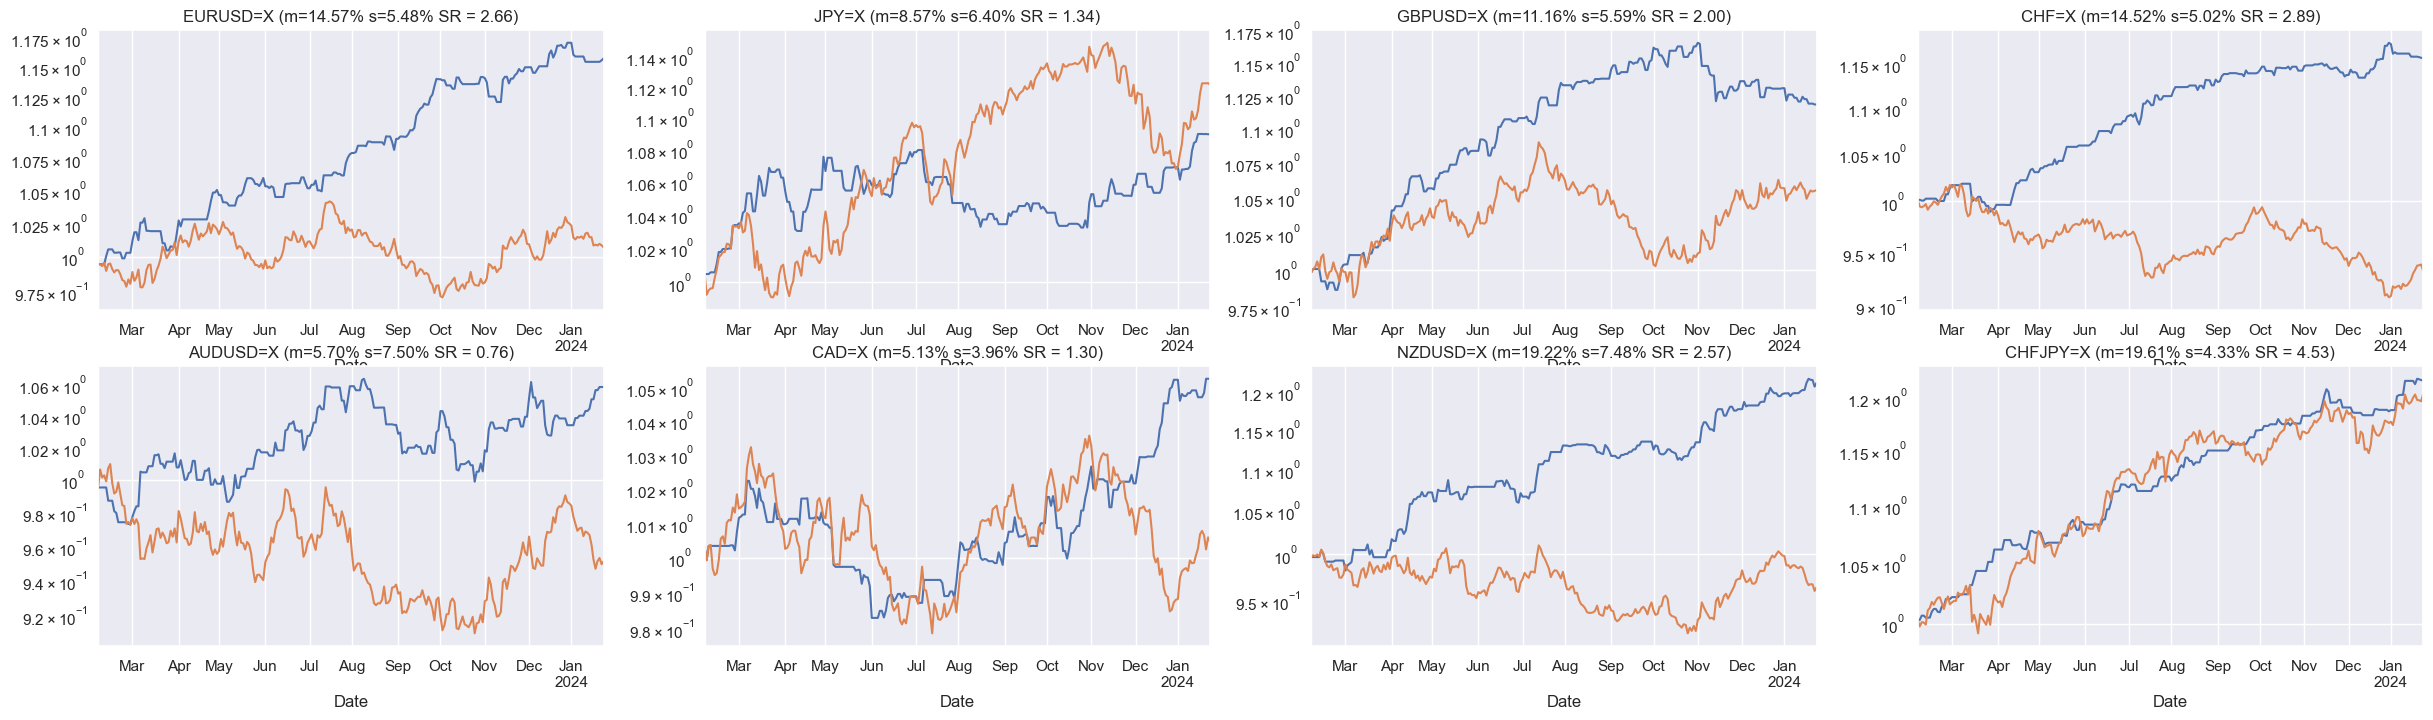

In [182]:
fig,axes = plt.subplots(2,4)
for i,symbol in enumerate(symbols):
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s

    r,c = i//4,i%4
    ax = axes[r,c]

    ax.set_title(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')
    ax.set_yscale('log')
    np.exp(df['Pnl'].cumsum()).plot(ax=ax)
    np.exp(df['Ret'].cumsum()).plot(ax=ax)

    '''
    ax2 = ax.twinx()
    temp = pd.DataFrame({'Long':df['Pos'][df['Pos']>=0],
                         'Short':df['Pos'][df['Pos']<0]})
    ax2.bar(temp.index,temp['Long'],alpha=0.7,color='green')
    ax2.bar(temp.index,temp['Short'],alpha=0.7,color='red')
    '''


In [186]:
test_return = pd.DataFrame()
for symbol in symbols:
    df = test_data[symbol]
    test_return[symbol] = df['Pnl']

### 100 simulations

In [39]:
def perform_test(col):
    train_data = dict()
    test_data = dict()
    frac = round(len(ta_data[symbols[0]]) * 0.2)
    frac = 252
    for symbol in symbols:
        train_data[symbol] = ta_data[symbol].iloc[-frac*6:-frac]
        test_data[symbol] = ta_data[symbol].iloc[-frac:]

    knns = [KNeighborsClassifier(n_neighbors=10) for _ in range(100)]
    for i,knn in enumerate(knns):
            bootstrap_train_data = concat_train_data.sample(frac=0.3,replace=True)
            knn.fit(X=bootstrap_train_data.iloc[:,1:],
                    y=np.sign(bootstrap_train_data.iloc[:,0]))
            
    for symbol in symbols:
        df = test_data[symbol]
        pos = pd.DataFrame()
        for i,knn in enumerate(knns):
            pos[f'{i}'] = knn.predict(df.iloc[:,1:])
        df['Pred'] = pos.mean(axis=1).to_numpy()
        df['Pos'] = (np.around(df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
        df['Pnl'] = df['Pos'] * df['Ret']
    
    test_return = pd.DataFrame()
    for symbol in symbols:
        df = test_data[symbol]
        test_return[symbol] = df['Pnl']
        port_return = test_return.mean(axis=1) * 100
    
    return port_return

simulated_returns = pd.DataFrame(columns=np.arange(100),index=test_data['AUDUSD=X'].index)
simulated_returns = simulated_returns.apply(perform_test,axis=0)

### Performance

In [184]:
test_return_weight = 1/test_return.rolling(30).std()
test_return_weight = test_return_weight.div(test_return_weight.sum(axis=1),axis=0)

Text(0.5, 1.0, 'Portfolio of 7 major pairs (m=200.87% s=21.53% SR = 9.33)')

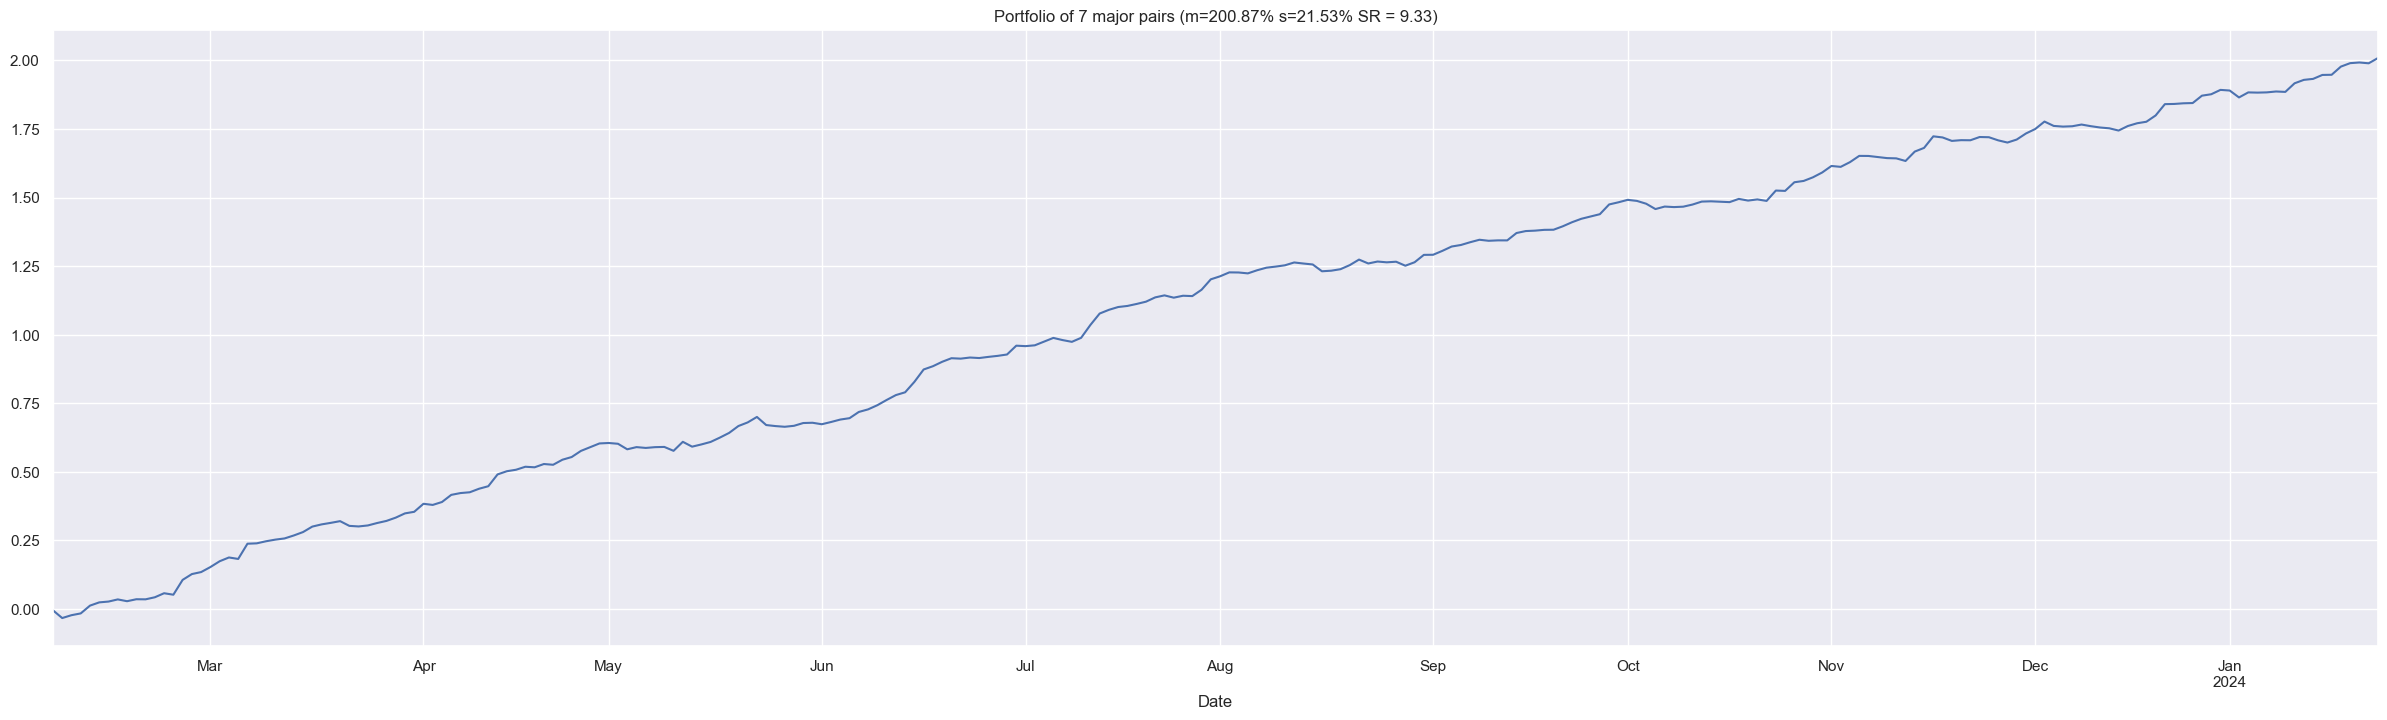

In [191]:
#port_return = (test_return * test_return_weight.shift(1)).sum(axis=1)
port_return = test_return.mean(axis=1) * 15

m = port_return.mean()*252
s = port_return.std()*252**0.5
SR = m/s

ax = port_return.cumsum().plot()
#ax.set_yscale('log')
ax.set_title(f'Portfolio of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

In [192]:
Evaluator(port_return).get_summary()

,Value,Sample size,P-value
Cum Return,6.2292,1.0000,NaN
Mean,2.0087,252.0000,NaN
Vol,0.2153,252.0000,NaN
SR,9.1501,252.0000,0.0000
CAPM Alpha,1.9885,207.0000,0.0000
Carhart Alpha,2.0099,207.0000,0.0000
Beta,0.1470,207.0000,0.1953
Skew,0.5682,252.0000,NaN
Skew (M),0.3975,12.0000,NaN
Kurt,1.4079,252.0000,NaN


## Walk forward test

### Split datasets

In [215]:
dates = pd.DataFrame()
dates['test_end'] = ta_data['JPY=X'].index[::-252]
dates['test_start'] = dates['test_end'].shift(-1)
dates['train_end'] = dates['test_start']
dates['train_start'] = dates['train_end'].shift(-5)
dates = dates.loc[dates.index[::-1]].iloc[6:].reset_index(drop=True)

In [216]:
train_data_list = list()
test_data_list = list()
for i in range(len(dates)):
    train_data = dict()
    test_data = dict()

    print(f'{i}-th dataset:')

    for symbol in symbols:
        train_start, train_end = dates.loc[i,'train_start'], dates.loc[i,'train_end']
        test_start, test_end = dates.loc[i,'test_start'], dates.loc[i,'test_end']

        train = ta_data[symbol].loc[:train_end]
        test = ta_data[symbol].loc[test_start:test_end].iloc[1:]

        train_data[symbol] = train
        test_data[symbol] = test
        #print(f'{symbol} {i}-th dataset: trained {train_start.date()} to {train_end.date()}, tested {test_start.date()} to {test_end.date()}')

        

        try:
            train_start_date = train.index[0].date()
            train_end_date = train.index[-1].date()
        except:
            train_start_date = '{NO DATA}'
            train_end_date = '{NO DATA}'

        try:
            test_start_date = test.index[0].date()
            test_end_date = test.index[-1].date()
        except:
            test_start_date = '{NO DATA}'
            test_end_date = '{NO DATA}'

        print(f'    {symbol} [{len(train)},{len(test)}]: trained {train_start_date} to {train_end_date}, tested {test_start_date} to {test_end_date}')

    train_data_list.append(train_data)
    test_data_list.append(test_data)

    print()

0-th dataset:
    EURUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    JPY=X [1267,252]: trained 1997-11-05 to 2002-09-12, tested 2002-09-13 to 2003-09-01
    GBPUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    CHF=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    AUDUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    CAD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    NZDUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}

1-th dataset:
    EURUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    JPY=X [1519,252]: trained 1997-11-05 to 2003-09-01, tested 2003-09-02 to 2004-08-18
    GBPUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    CHF=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    AUDUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DAT

### Walk-forward testing

In [217]:
knns_list = list()
for i,train_data in enumerate(train_data_list):
    print(f'Training {i}-th dataset')
    #print(train_data.keys())
    concat_train_data = pd.concat(train_data.values())
    knns = [KNeighborsClassifier(n_neighbors=10) for _ in range(100)]
    for i,knn in enumerate(knns):
        bootstrap_train_data = concat_train_data.sample(frac=0.3,replace=True)
        knn.fit(X=bootstrap_train_data.iloc[:,1:],
            y=np.sign(bootstrap_train_data.iloc[:,0]))
    knns_list.append(knns)

Training 0-th dataset
Training 1-th dataset
Training 2-th dataset
Training 3-th dataset
Training 4-th dataset
Training 5-th dataset
Training 6-th dataset
Training 7-th dataset
Training 8-th dataset
Training 9-th dataset
Training 10-th dataset
Training 11-th dataset
Training 12-th dataset
Training 13-th dataset
Training 14-th dataset
Training 15-th dataset
Training 16-th dataset
Training 17-th dataset
Training 18-th dataset
Training 19-th dataset
Training 20-th dataset
Training 21-th dataset


In [218]:
for i,(test_data,knns_list) in enumerate(zip(test_data_list,knns_list)):
    print(f'Trading {i}-th dataset')
    for symbol in symbols:
        df = test_data[symbol]
        pos = pd.DataFrame()
        if len(df) > 0:
            for i,knn in enumerate(knns):
                pos[f'{i}'] = knn.predict(df.iloc[:,1:])
            df['Pred'] = pos.mean(axis=1).to_numpy()
            df['Pos'] = np.around((df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
            #df['Pos'] = np.around(df['Pred']*5)/5
            df['Pnl'] = df['Pos'] * df['Ret']

Trading 0-th dataset
Trading 1-th dataset
Trading 2-th dataset
Trading 3-th dataset
Trading 4-th dataset
Trading 5-th dataset
Trading 6-th dataset
Trading 7-th dataset
Trading 8-th dataset
Trading 9-th dataset
Trading 10-th dataset
Trading 11-th dataset
Trading 12-th dataset
Trading 13-th dataset
Trading 14-th dataset
Trading 15-th dataset
Trading 16-th dataset
Trading 17-th dataset
Trading 18-th dataset
Trading 19-th dataset
Trading 20-th dataset
Trading 21-th dataset


### Performance

In [197]:
test_return_list = list()
for i,test_data in enumerate(test_data_list):
    test_return = pd.DataFrame()
    for symbol in symbols:
        if len(test_data[symbol]) > 0:
            test_return[symbol] = test_data[symbol]['Pnl']
    test_return['Port'] = test_return.mean(axis=1)
    test_return_list.append(test_return)

Text(0.5, 1.0, 'Walk-forward portfolio return of 7 major pairs (m=17.75% s=2.13% SR = 8.32)')

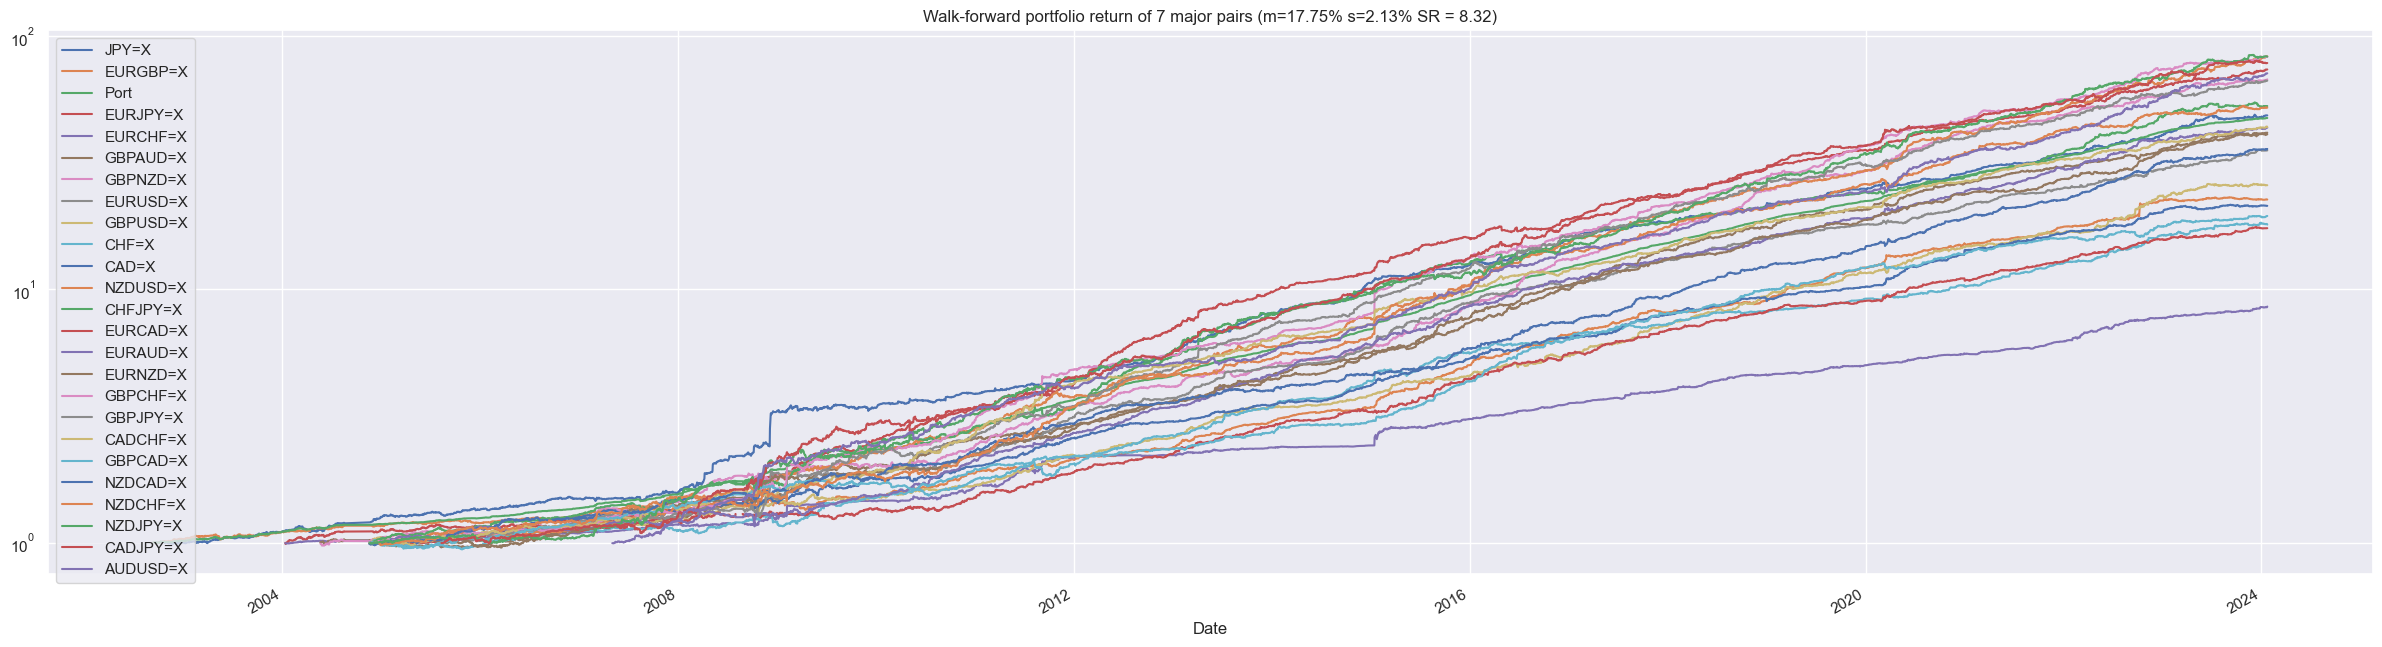

In [199]:
concat_test_return = pd.concat(test_return_list,axis=0)

ax = np.exp(concat_test_return.cumsum()).plot()
ax.set_yscale('log')

m = concat_test_return['Port'].mean()*252
s = concat_test_return['Port'].std()*252**0.5
SR = m/s

ax.set_title(f'Walk-forward portfolio return of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

In [200]:
Evaluator(concat_test_return['Port']).get_summary()

,Value,Sample size,P-value
Cum Return,46.1649,1.0000,NaN
Mean,0.1775,5480.0000,NaN
Vol,0.0213,5480.0000,NaN
SR,5.0688,5480.0000,0.0000
CAPM Alpha,0.0599,207.0000,0.0000
Carhart Alpha,0.0614,207.0000,0.0000
Beta,0.0062,207.0000,0.3134
Skew,3.1524,5480.0000,NaN
Skew (M),0.8051,257.0000,NaN
Kurt,58.5004,5480.0000,NaN


<Axes: ylabel='Frequency'>

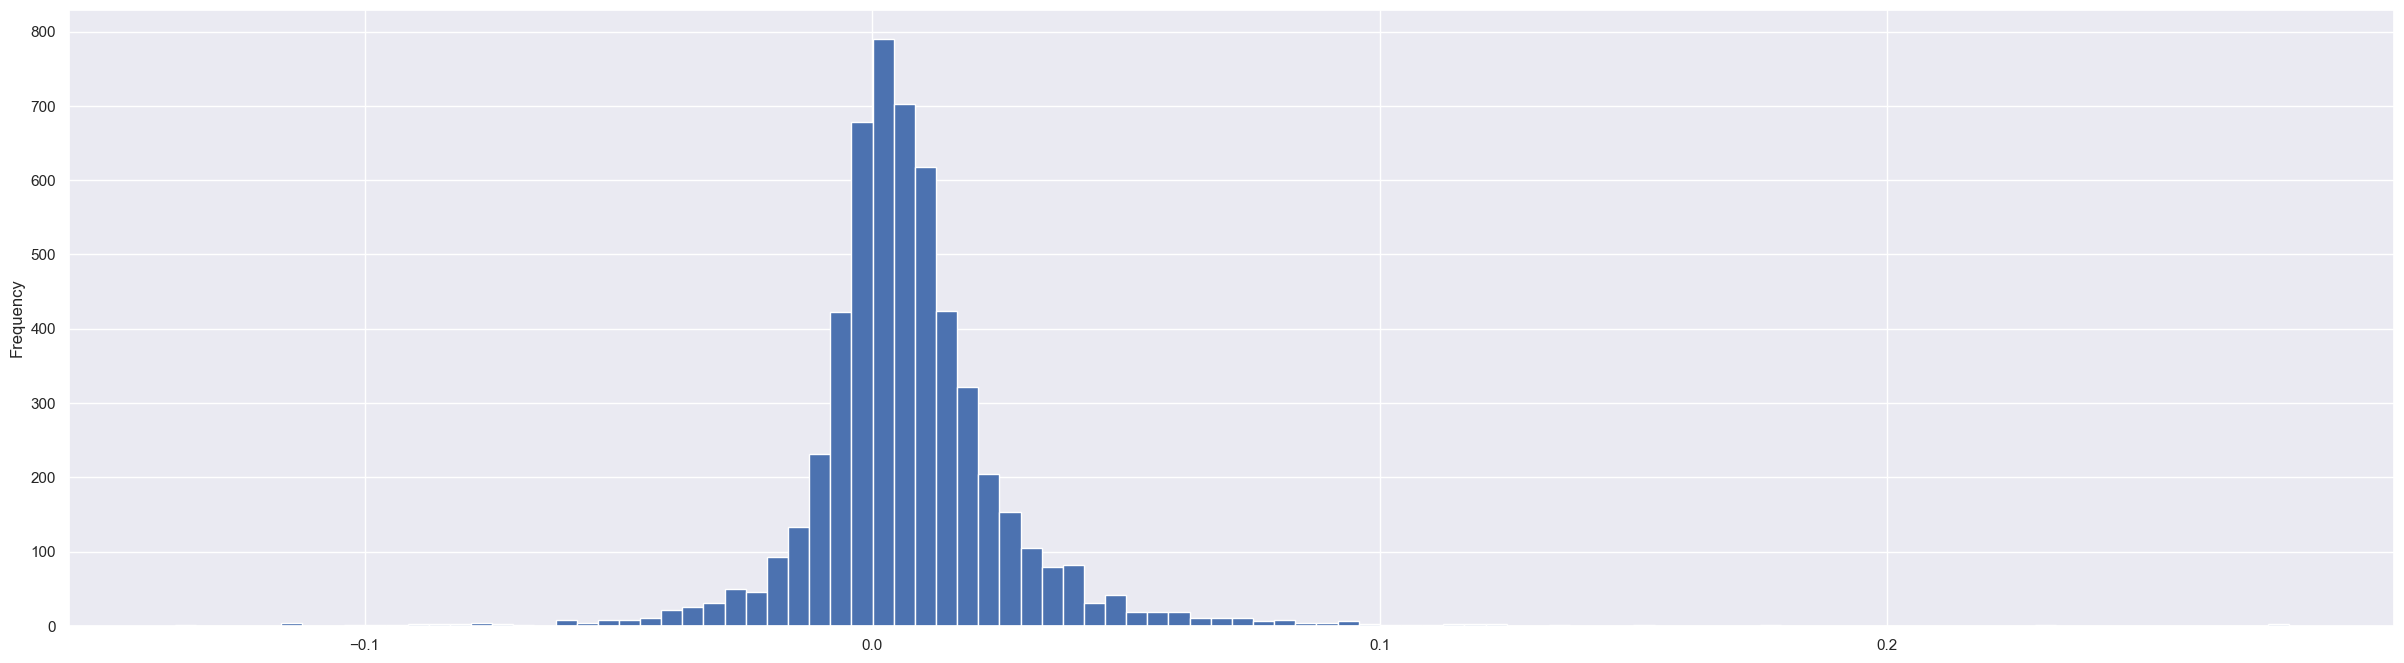

In [135]:
port_return.plot(kind='hist',bins=100)

<Axes: xlabel='Date'>

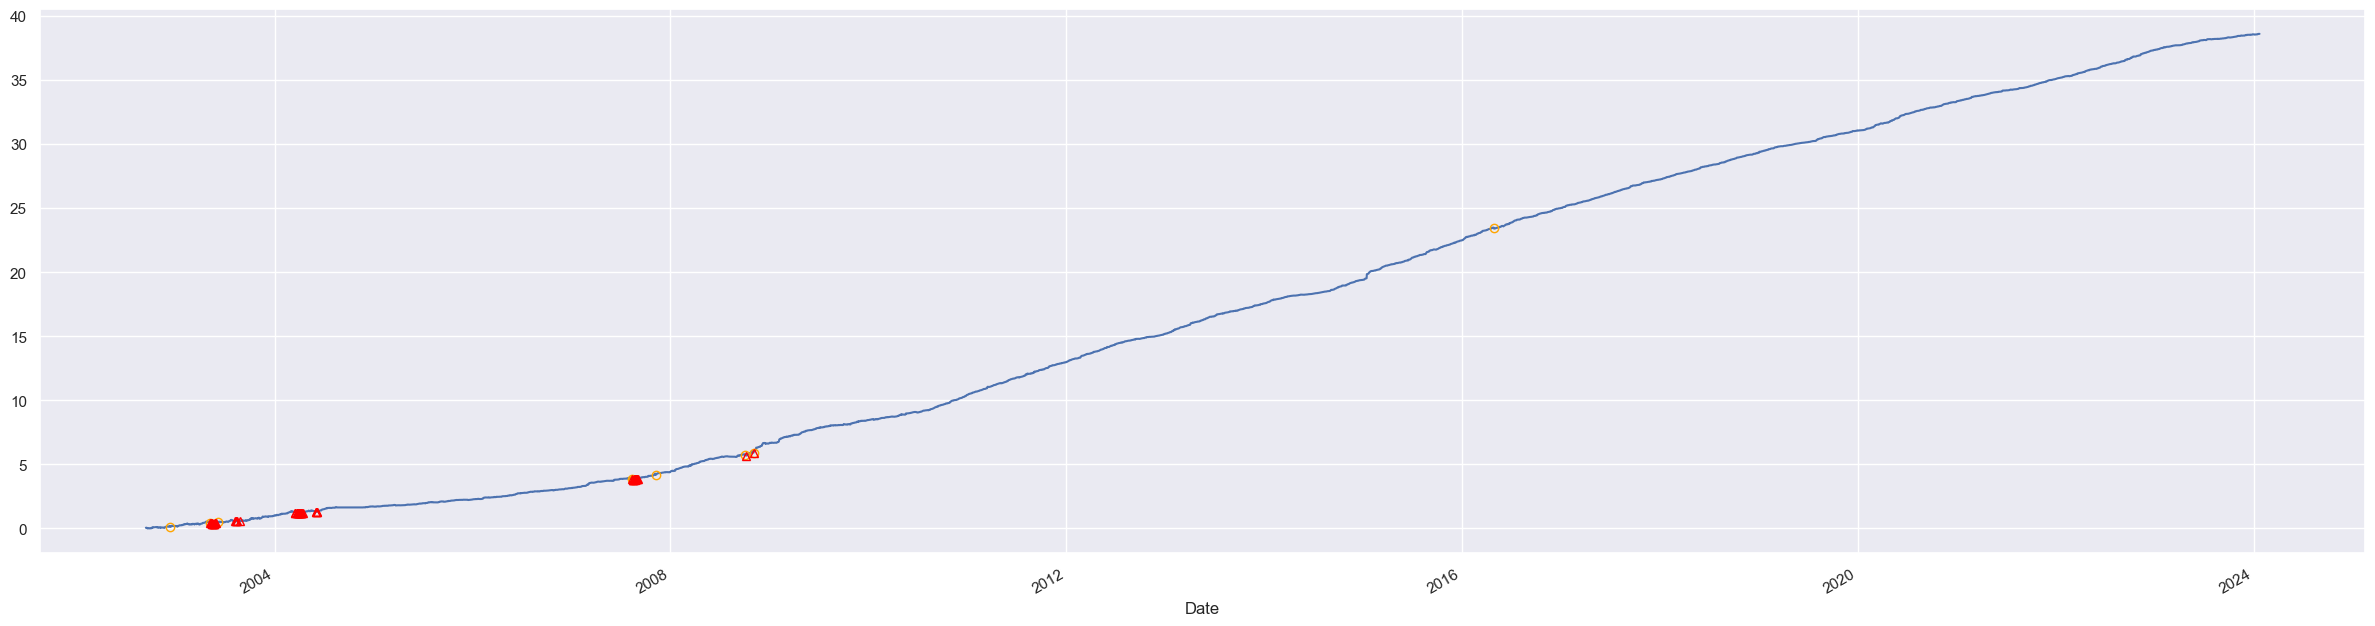

In [237]:
port_return = concat_test_return['Port']*10
cum_return = (port_return.cumsum())
cum_loss = cum_return - cum_return.cummax()

ax = cum_return.plot()
cum_return[port_return<-0.05].plot(marker='o',linestyle='None',markeredgecolor='orange',color='None')
cum_return[cum_loss<-0.10].plot(marker='^',linestyle='None',markeredgecolor='red',color='None')

In [239]:
cum_loss[cum_loss<0].quantile(0.01)

-0.13341268505852713

In [147]:
port_return[port_return<-0.05].count()

28

In [148]:
cum_loss[cum_loss<-0.10].count()

203

In [137]:
m = concat_test_return.mean()*252
s = concat_test_return.std()*np.sqrt(252)
SR = m/s
pd.DataFrame({'Mean':m,
              'Vol':s,
              'SR':SR})

,Mean,Vol,SR
JPY=X,0.1756,0.0729,2.4095
Port,0.1724,0.0333,5.1775
EURUSD=X,0.1788,0.0706,2.5331
GBPUSD=X,0.1556,0.0552,2.8215
CHF=X,0.1721,0.0661,2.6042
CAD=X,0.1303,0.0505,2.5817
NZDUSD=X,0.2127,0.0693,3.0685
AUDUSD=X,0.2552,0.0766,3.3315


<Axes: title={'center': 'Rolling 1-year SR'}, xlabel='Date'>

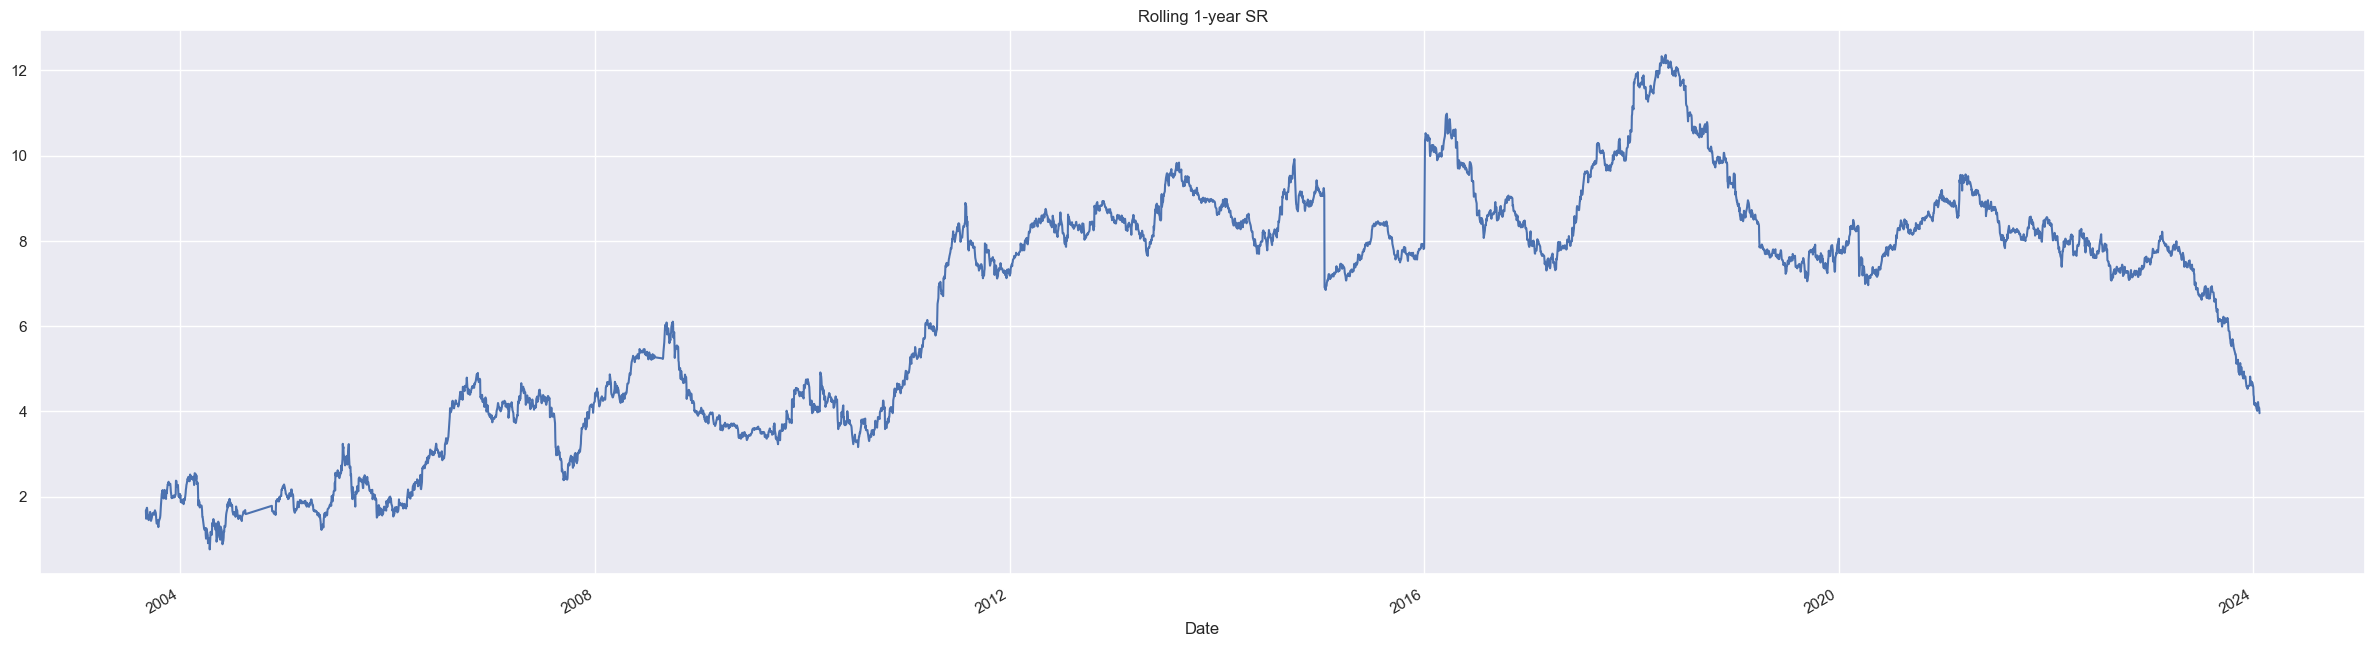

In [138]:
i = 1

m = concat_test_return['Port'].rolling(252*i).mean() * 252
s = concat_test_return['Port'].rolling(252*i).std() * np.sqrt(252)
SR = m/s

SR.plot(title=f'Rolling {i}-year SR')

### Net cost

In [82]:
test_pos_list = list()
test_pred_list = list()
for i,test_data in enumerate(test_data_list):
    test_pos = pd.DataFrame()
    test_pred = pd.DataFrame()
    for symbol in symbols:
        if len(test_data[symbol]) > 0:
            test_pos[symbol] = test_data[symbol]['Pos']
            test_pred[symbol] = (np.sign(test_data[symbol]['Pred']) == np.sign(test_data[symbol]['Ret']))
    test_pos_list.append(test_pos)
    test_pred_list.append(test_pred)

In [292]:
spread = 0.0001

concat_test_pos = pd.concat(test_pos_list,axis=0)
cost = concat_test_pos.diff() * spread

netcost_test_return = concat_test_return - cost
netcost_test_return['Port'] = netcost_test_return.mean(axis=1)

Text(0.5, 1.0, 'Walk-forward portfolio return of 7 major pairs (m=16.93% s=3.26% SR = 5.19)')

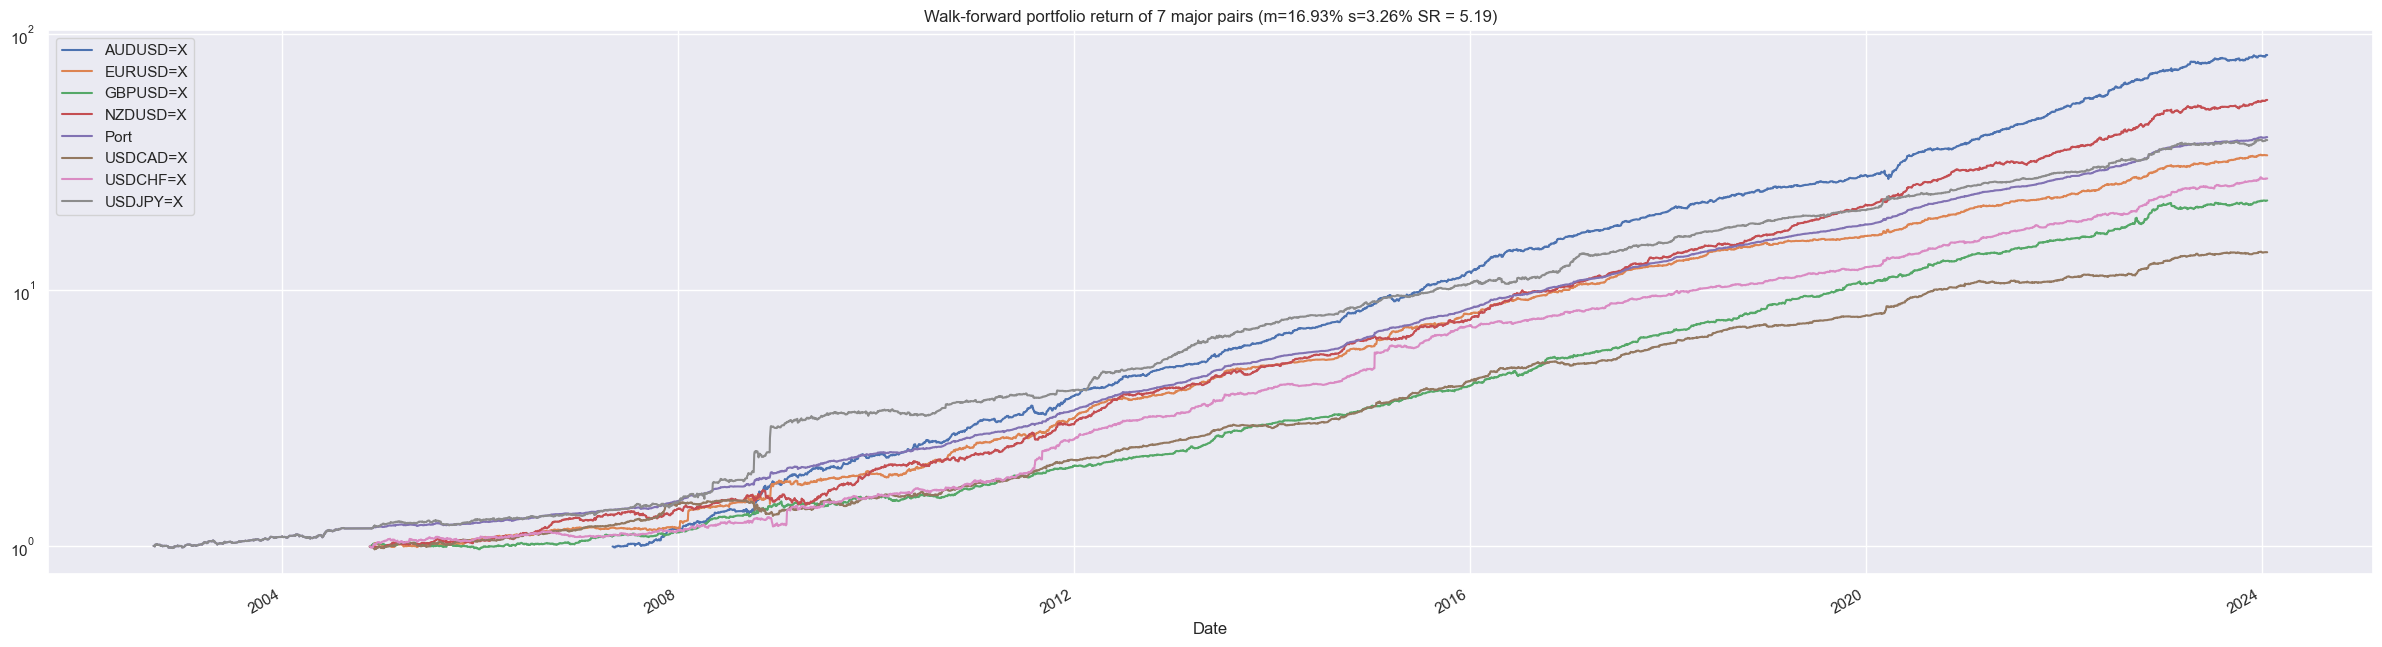

In [293]:
ax = np.exp(netcost_test_return.cumsum()).plot()
ax.set_yscale('log')

m = netcost_test_return['Port'].mean()*252
s = netcost_test_return['Port'].std()*252**0.5
SR = m/s

ax.set_title(f'Walk-forward portfolio return of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')